In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn import metrics

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import PaddedGraphGenerator
from stellargraph.layer import DeepGraphCNN

from tensorflow.python import keras
from keras import Model
from keras.optimizers import Adam
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
from keras.losses import binary_crossentropy
from keras.callbacks import EarlyStopping

from imblearn.under_sampling import CondensedNearestNeighbour, NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [2]:
MID_LIST = []

def normalize(X):
    for column in X.columns:
        mid = (X[column].max() + X[column].min()) / 2
        X[column] = (X[column] - mid)  / (X[column].max() - mid)
        MID_LIST.append(mid)

def create_graph_list(X):
    
    graph = []
    
    columns = X.columns.tolist()
    
    # ,['cviec','pxuong']
    relation_ship = [['cviec1','tgian1'],['cviec2','tgian2'],['tuoinghe','A9a','A9b','nampx'],
                      ['hutthuoc','slthuoc'],['tiensuhh','benhhh'],['ho','tdho','tsho'],
                      ['khacdom','loaidom','tdkhacdo'],['khotho','mdkhotho','tdkhotho'],
                      ['daunguc','vitridau','daulan','tcdau','tgdau','ytodau'],
                      ['sutcan','socansut','tgsut'],['fvclt','fev1lt']]
    
    for tmp_i in range(len(relation_ship)):
        for tmp_j in range(len(relation_ship[tmp_i])):
            relation_ship[tmp_i][tmp_j] = columns.index(relation_ship[tmp_i][tmp_j])
    
    for i in tqdm(range(X.shape[0])):
        source = []
        target = []
        value = []
        indexing = []
        
        for j in range (0, X.shape[1]):
            if not np.isnan(X.iloc[i][j]):
                source.append(0)
                target.append(j)
                value.append(X.iloc[i][j])
                indexing.append(j)   
                
        for j in range(len(relation_ship)):
            flg = True
            for xx in relation_ship[j]:
                if np.isnan(X.iloc[i][xx]):
                    flg = False
                    break
            if flg:
                for xx in relation_ship[j]:
                    source.append(relation_ship[j][0])
                    target.append(xx) 
                
        sg_tmp = pd.DataFrame(
            {"source": source, "target": target}
        )
        sg_tmp_data = pd.DataFrame(
            {"value": value}, 
             index = indexing
        )
        
        sg = StellarGraph(sg_tmp_data, sg_tmp)
        graph.append(sg)
        
    return graph

In [3]:
df = pd.read_excel("Main_data_fixed_ver08.xlsx")
# df = pd.read_excel("Main_data_fixed_Fill_Na.xlsx");

# df.drop(columns=['tinh','hoten','gioitinh','namsinh','sdt','cviec','pxuong'], inplace=True)

In [4]:
X, Y = df.iloc[:, :-1], df.iloc[:, -1]   

normalize(X)

In [85]:
print("======Counter of Y======")
print(Counter(Y))
print(Y)

======Counter of Y======
Counter({0: 7819, 1: 211})
0       0
1       0
2       0
3       0
4       0
       ..
8025    0
8026    0
8027    0
8028    0
8029    0
Name: bnn, Length: 8030, dtype: int64


In [5]:
undersample = RandomUnderSampler(sampling_strategy=0.05)
# undersample = CondensedNearestNeighbour(n_neighbors=1)

tmp_X = X.copy()

X, Y = undersample.fit_resample(X, Y)

C:\Users\vvt\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\vvt\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\vvt\anaconda3\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\vvt\anaconda3\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_

In [107]:
print("======Counter of Y======")
print(Counter(Y))
print(Y)

======Counter of Y======
Counter({0: 4220, 1: 211})
0       0
1       0
2       0
3       0
4       0
       ..
4426    1
4427    1
4428    1
4429    1
4430    1
Name: bnn, Length: 4431, dtype: int64


In [120]:
# Split data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.3, shuffle=True, random_state=100)

_, x_test1, _, y_test1 = train_test_split(X, Y, train_size=0.1, shuffle=True, random_state=100)

_, X_pre, _, Y_pre = train_test_split(x_test1, y_test1, train_size=0.5, shuffle=True, random_state=101)

X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)
X_pre = X_pre.reset_index(drop=True)
Y_pre = Y_pre.reset_index(drop=True)

print("======Counter of Y train======")
print(Counter(Y_train))

print("======Counter of Y test======")
print(Counter(Y_test))

print("======Counter of Y pre======")
print(Counter(Y_pre))
 
# graph_X =  create_graph_list(X) 
graph_X =  create_graph_list(tmp_X)
graph_train = create_graph_list(X_train)
graph_test = create_graph_list(X_test)
graph_pre = create_graph_list(X_pre)

# =============================================================================
# print('graph info(1 Graph):')
# print(graph_train[0].info())
# print('data of a graph(only node value):')
# print(graph_train[0].node_features())
# =============================================================================

X_generator = PaddedGraphGenerator(graphs=graph_X)

======Counter of Y train======
Counter({0: 1263, 1: 66})
======Counter of Y test======
Counter({0: 2957, 1: 145})
======Counter of Y pre======
Counter({0: 1903, 1: 91})


100%|██████████████████████████████████████████████████████████████████████████████| 1994/1994 [00:47<00:00, 42.23it/s]


Model 1 - 100 epoch - train split 0.7 - kernel_size 50 - 100 batch - resample 0.05
Model: "model_46"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_142 (InputLayer)         [(None, None, 1)]    0           []                               
                                                                                                  
 dropout_253 (Dropout)          (None, None, 1)      0           ['input_142[0][0]']              
                                                                                                  
 input_144 (InputLayer)         [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_c

C:\Users\vvt\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_46/sort_pooling_50/map/while/gradients/model_46/sort_pooling_50/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_46/sort_pooling_50/map/while/gradients/model_46/sort_pooling_50/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_46/sort_pooling_50/map/while/gradients/model_46/sort_pooling_50/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


14/14 [==============================] - 9s 530ms/step - loss: 0.2847 - acc: 0.9225 - val_loss: 0.1555 - val_acc: 0.9536
Epoch 2/150
14/14 [==============================] - 7s 498ms/step - loss: 0.1540 - acc: 0.9549 - val_loss: 0.1312 - val_acc: 0.9558
Epoch 3/150
14/14 [==============================] - 7s 499ms/step - loss: 0.1463 - acc: 0.9556 - val_loss: 2.4094 - val_acc: 0.0957
Epoch 4/150
14/14 [==============================] - 7s 503ms/step - loss: 0.4369 - acc: 0.8593 - val_loss: 0.1704 - val_acc: 0.9533
Epoch 5/150
14/14 [==============================] - 7s 501ms/step - loss: 0.1721 - acc: 0.9503 - val_loss: 0.1591 - val_acc: 0.9533
Epoch 6/150
14/14 [==============================] - 7s 499ms/step - loss: 0.1589 - acc: 0.9526 - val_loss: 0.1509 - val_acc: 0.9533
Epoch 7/150
14/14 [==============================] - 7s 528ms/step - loss: 0.1498 - acc: 0.9481 - val_loss: 0.1328 - val_acc: 0.9558
Epoch 8/150
14/14 [==============================] - 7s 526ms/step - loss: 0.1556

14/14 [==============================] - 7s 512ms/step - loss: 0.0086 - acc: 0.9955 - val_loss: 0.4069 - val_acc: 0.9520
Epoch 124/150
14/14 [==============================] - 7s 524ms/step - loss: 0.0063 - acc: 0.9985 - val_loss: 0.4582 - val_acc: 0.9539
Epoch 125/150
14/14 [==============================] - 7s 519ms/step - loss: 0.0098 - acc: 0.9970 - val_loss: 0.4281 - val_acc: 0.9513
Epoch 126/150
14/14 [==============================] - 7s 510ms/step - loss: 0.0073 - acc: 0.9977 - val_loss: 0.4290 - val_acc: 0.9442
Epoch 127/150
14/14 [==============================] - 7s 528ms/step - loss: 0.0071 - acc: 0.9962 - val_loss: 0.4471 - val_acc: 0.9504
Epoch 128/150
14/14 [==============================] - 7s 508ms/step - loss: 0.0119 - acc: 0.9970 - val_loss: 0.4603 - val_acc: 0.9536
Epoch 129/150
14/14 [==============================] - 7s 511ms/step - loss: 0.0075 - acc: 0.9977 - val_loss: 0.4269 - val_acc: 0.9523
Epoch 130/150
14/14 [==============================] - 7s 520ms/step 

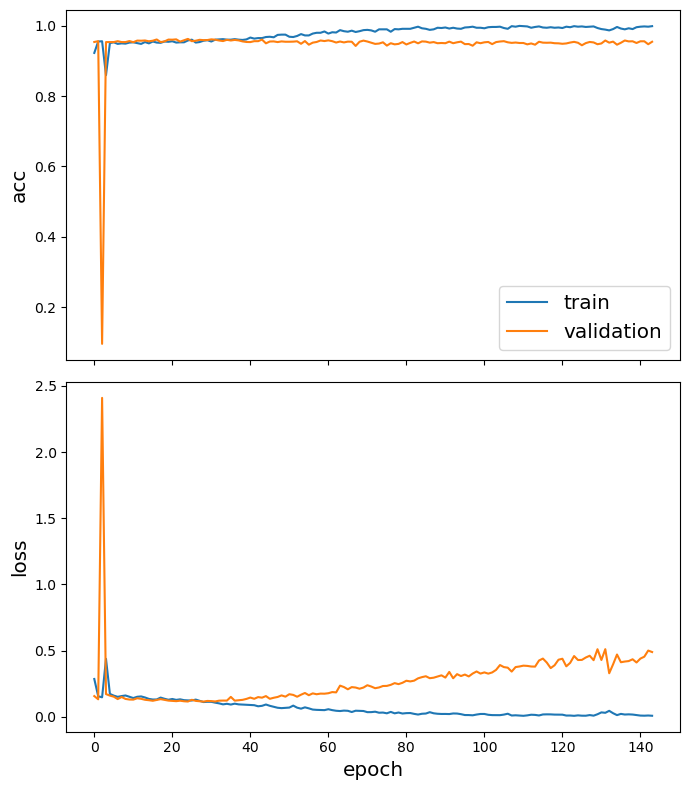

In [125]:
# Train model 1
# Model 1

# simple early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

print('Model 1 - 100 epoch - train split 0.7 - kernel_size 50 - 100 batch - resample 0.05')
k = 135  # the number of rows for the output tensor
layer_sizes = [128, 128, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=X_generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()


x_out = Conv1D(filters=256, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)
x_out = Dropout(rate=0.2)(x_out)

x_out = Conv1D(filters=128, kernel_size=50, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=64, activation="relu")(x_out)
x_out = Dropout(rate=0.2)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

model = Model(inputs=x_inp, outputs=predictions)

model.summary()

model.compile(
    optimizer=Adam(lr=0.0005), loss=binary_crossentropy, metrics=["acc"],
)

# loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=1)

#Create generator
train_generator = PaddedGraphGenerator(graphs=graph_train)
test_generator = PaddedGraphGenerator(graphs=graph_test)
pre_generator = PaddedGraphGenerator(graphs=graph_pre)

train_gen = train_generator.flow(
    X_train.index,
    targets=list(Y_train),
    batch_size=100,
    symmetric_normalization=False,
)

test_gen = test_generator.flow(
    X_test.index,
    targets=list(Y_test),
    batch_size=100,
    symmetric_normalization=False,
)

history = model.fit(
    train_gen, epochs=150, verbose=1, validation_data=test_gen, shuffle=True, callbacks=[es]
)

sg.utils.plot_history(history)

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:44<00:00, 10.56it/s]


3000/3000 [==============================] - 20s 7ms/step
pre : actual
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
1   :   0
0   :   0
0   :   0
0   :   0
0   :   0
1   :   1
0   :   0
0   :   0
0   :   0
acc: 0.985
2955
Thống kê bộ data predict:
Counter({0: 2924, 1: 76})
Thống kê bộ data actual:
Counter({0: 2923, 1: 77})
f1_score: 0.7058823529411765
precision_score: 0.7012987012987013
recall_score: 0.7105263157894737
Confusion Matrix:


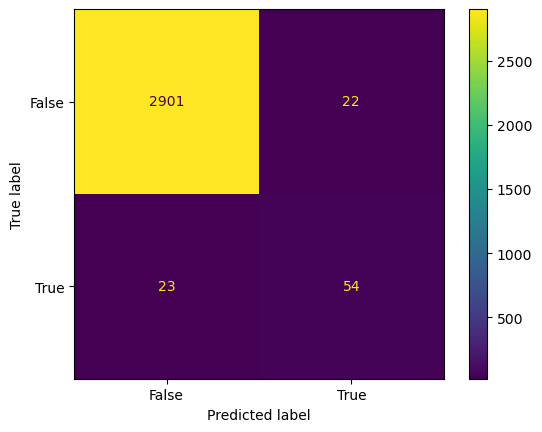

In [111]:
# Test model data real
df_pred_test_ac = df.sample(n=3000).reset_index(drop=True)

# df_pred_test_ac = df

X_pre_ac = df_pred_test_ac.iloc[:,:-1]
normalize(X_pre_ac)
Y_pre_ac = df_pred_test_ac.iloc[:,-1]

graph_X_ac =  create_graph_list(X_pre_ac)

pre_generator_ac = PaddedGraphGenerator(graphs=graph_X_ac)

t_gen = pre_generator_ac.flow(
    Y_pre_ac.index,
    symmetric_normalization=False,
) 
pre = [round(i[0]) for i in model.predict(t_gen)]
actual = [i for i in Y_pre_ac.values]

counter = 0

print('pre : actual')
for i in range(len(pre)):
    if(counter < 25):
        print(f'{pre[i]}   :   {actual[i]}')
    if pre[i] == actual[i]:
        counter += 1

print(f'acc: {counter/len(pre)}')
print(counter)

from collections import Counter

print("Thống kê bộ data predict:")
print(Counter(pre))
print("Thống kê bộ data actual:")
print(Counter(actual))

print(f'f1_score: {f1_score(pre, actual)}')
print(f'precision_score: {precision_score(pre, actual)}')
print(f'recall_score: {recall_score(pre, actual)}')

print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(actual, pre)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 8030/8030 [13:25<00:00,  9.97it/s]


8030/8030 [==============================] - 57s 7ms/step
pre : actual
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
1   :   0
0   :   0
acc: 0.9719800747198007
7805
Thống kê bộ data predict:
Counter({0: 7764, 1: 266})
Thống kê bộ data actual:
Counter({0: 7819, 1: 211})
f1_score: 0.5283018867924528
precision_score: 0.5971563981042654
recall_score: 0.47368421052631576
Confusion Matrix:


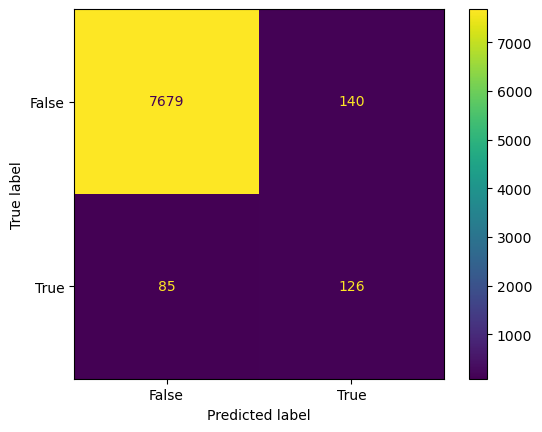

In [130]:
# Test model data real
df_pred_test_ac = df.iloc[:].reset_index(drop=True)

# df_pred_test_ac = df

X_pre_ac = df_pred_test_ac.iloc[:,:-1]
normalize(X_pre_ac)
Y_pre_ac = df_pred_test_ac.iloc[:,-1]

graph_X_ac =  create_graph_list(X_pre_ac)

pre_generator_ac = PaddedGraphGenerator(graphs=graph_X_ac)

t_gen = pre_generator_ac.flow(
    Y_pre_ac.index,
    symmetric_normalization=False,
) 
pre = [round(i[0]) for i in model.predict(t_gen)]
actual = [i for i in Y_pre_ac.values]

counter = 0

print('pre : actual')
for i in range(len(pre)):
    if(counter < 25):
        print(f'{pre[i]}   :   {actual[i]}')
    if pre[i] == actual[i]:
        counter += 1

print(f'acc: {counter/len(pre)}')
print(counter)

from collections import Counter

print("Thống kê bộ data predict:")
print(Counter(pre))
print("Thống kê bộ data actual:")
print(Counter(actual))

print(f'f1_score: {f1_score(pre, actual)}')
print(f'precision_score: {precision_score(pre, actual)}')
print(f'recall_score: {recall_score(pre, actual)}')

print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(actual, pre)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

3000/3000 [==============================] - 21s 7ms/step


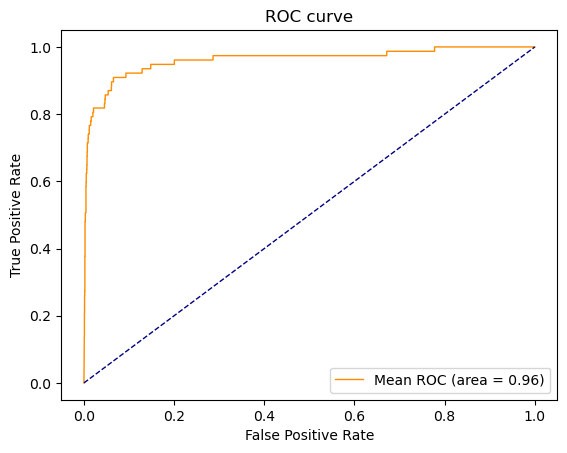

In [112]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

y_score = [i[0] for i in model.predict(t_gen)]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(actual[:], y_score[:])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(actual, y_score)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 1
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="Mean ROC (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

Model 2 - 100 epoch - 0.7 - kernel_size 25 - 100 batch - 0.2
Epoch 1/100


C:\Users\vvt\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model_9/sort_pooling_9/map/while/gradients/model_9/sort_pooling_9/map/while/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model_9/sort_pooling_9/map/while/gradients/model_9/sort_pooling_9/map/while/GatherV2_grad/Reshape:0", shape=(None, None), dtype=float32), dense_shape=Tensor("gradient_tape/model_9/sort_pooling_9/map/while/gradients/model_9/sort_pooling_9/map/while/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


9/9 [==============================] - 6s 527ms/step - loss: 0.6324 - acc: 0.6659 - val_loss: 0.5414 - val_acc: 0.7711
Epoch 2/100
9/9 [==============================] - 5s 584ms/step - loss: 0.4314 - acc: 0.8296 - val_loss: 0.3522 - val_acc: 0.8316
Epoch 3/100
9/9 [==============================] - 4s 464ms/step - loss: 0.3185 - acc: 0.8612 - val_loss: 0.2934 - val_acc: 0.8763
Epoch 4/100
9/9 [==============================] - 4s 467ms/step - loss: 0.2928 - acc: 0.8736 - val_loss: 0.3008 - val_acc: 0.8789
Epoch 5/100
9/9 [==============================] - 4s 457ms/step - loss: 0.2652 - acc: 0.8849 - val_loss: 0.2839 - val_acc: 0.8868
Epoch 6/100
9/9 [==============================] - 4s 471ms/step - loss: 0.2534 - acc: 0.8962 - val_loss: 0.2622 - val_acc: 0.8921
Epoch 7/100
9/9 [==============================] - 4s 461ms/step - loss: 0.2428 - acc: 0.8950 - val_loss: 0.2671 - val_acc: 0.8895
Epoch 8/100
9/9 [==============================] - 4s 457ms/step - loss: 0.2454 - acc: 0.8984 -

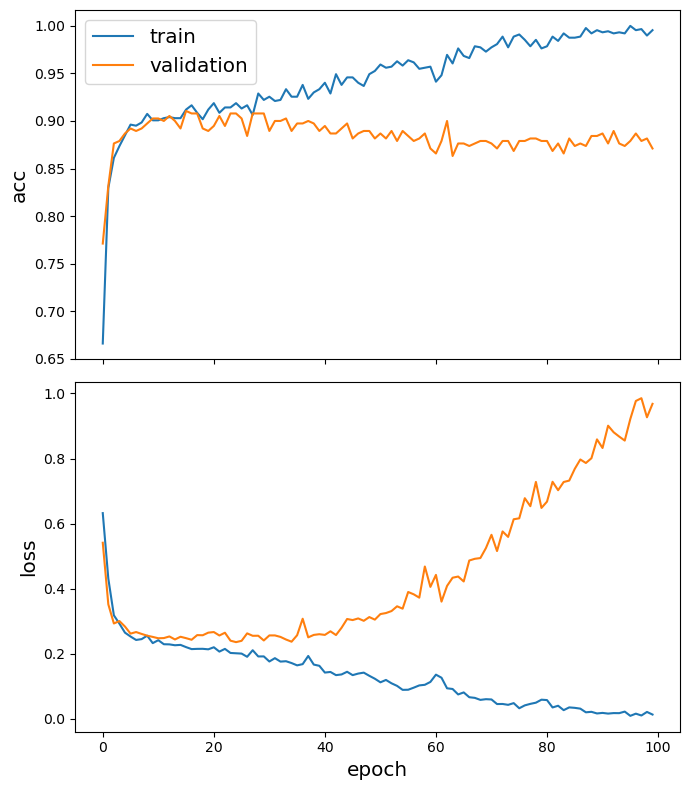

In [42]:
# Train model 2
# Model 2
print('Model 2 - 100 epoch - train split 0.7 - kernel_size 50 - 100 batch - resample 0.3')
k = 150  # the number of rows for the output tensor
layer_sizes = [128, 128, 128, 1]

dgcnn_model = DeepGraphCNN(
    layer_sizes=layer_sizes,
    activations=["tanh", "tanh", "tanh", "tanh"],
    k=k,
    bias=False,
    generator=X_generator,
)
x_inp, x_out = dgcnn_model.in_out_tensors()


x_out = Conv1D(filters=256, kernel_size=sum(layer_sizes), strides=sum(layer_sizes))(x_out)
x_out = MaxPool1D(pool_size=2)(x_out)
x_out = Dropout(rate=0.1)(x_out)

x_out = Conv1D(filters=128, kernel_size=50, strides=1)(x_out)

x_out = Flatten()(x_out)

x_out = Dense(units=64, activation="relu")(x_out)
x_out = Dropout(rate=0.1)(x_out)

predictions = Dense(units=1, activation="sigmoid")(x_out)

model = Model(inputs=x_inp, outputs=predictions)

# model.summary()

model.compile(
    optimizer=Adam(lr=0.0005), loss=binary_crossentropy, metrics=["acc"],
)

# loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_test, verbose=1)

#Create generator
train_generator = PaddedGraphGenerator(graphs=graph_train)
test_generator = PaddedGraphGenerator(graphs=graph_test)
pre_generator = PaddedGraphGenerator(graphs=graph_pre)

train_gen = train_generator.flow(
    X_train.index,
    targets=list(Y_train),
    batch_size=100,
    symmetric_normalization=False,
)

test_gen = test_generator.flow(
    X_test.index,
    targets=list(Y_test),
    batch_size=100,
    symmetric_normalization=False,
)

history = model.fit(
    train_gen, epochs=100, verbose=1, validation_data=test_gen, shuffle=True,
)

sg.utils.plot_history(history)

570/570 [==============================] - 5s 7ms/step
pre : actual
0   :   0
0   :   0
1   :   1
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
1   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
1   :   1
1   :   1
0   :   0
1   :   1
0   :   0
0   :   0
1   :   1
0   :   0
0   :   0
0   :   0
0   :   0
acc: 0.956140350877193
545
Thống kê bộ data predict:
Counter({0: 463, 1: 107})
Thống kê bộ data actual:
Counter({0: 464, 1: 106})
f1_score: 0.8826291079812206
precision_score: 0.8867924528301887
recall_score: 0.8785046728971962
Confusion Matrix:


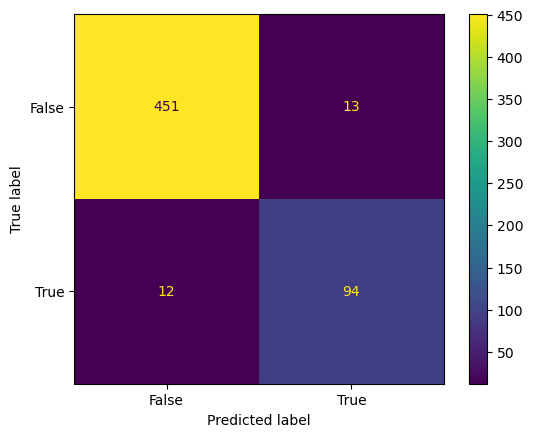

In [43]:
# Test model
t_gen = pre_generator.flow(
    X_pre.index,
    symmetric_normalization=False,
) 
pre = [round(i[0]) for i in model.predict(t_gen)]
actual = [i for i in Y_pre.values]

counter = 0

print('pre : actual')
for i in range(len(pre)):
    if(counter < 25):
        print(f'{pre[i]}   :   {actual[i]}')
    if pre[i] == actual[i]:
        counter += 1

print(f'acc: {counter/len(pre)}')
print(counter)

from collections import Counter

print("Thống kê bộ data predict:")
print(Counter(pre))
print("Thống kê bộ data actual:")
print(Counter(actual))

print(f'f1_score: {f1_score(pre, actual)}')
print(f'precision_score: {precision_score(pre, actual)}')
print(f'recall_score: {recall_score(pre, actual)}')

print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(actual, pre)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [04:50<00:00, 10.33it/s]


3000/3000 [==============================] - 23s 7ms/step
pre : actual
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
0   :   0
acc: 0.9366666666666666
2810
Thống kê bộ data predict:
Counter({0: 2772, 1: 228})
Thống kê bộ data actual:
Counter({0: 2918, 1: 82})
f1_score: 0.3870967741935484
precision_score: 0.7317073170731707
recall_score: 0.2631578947368421
Confusion Matrix:


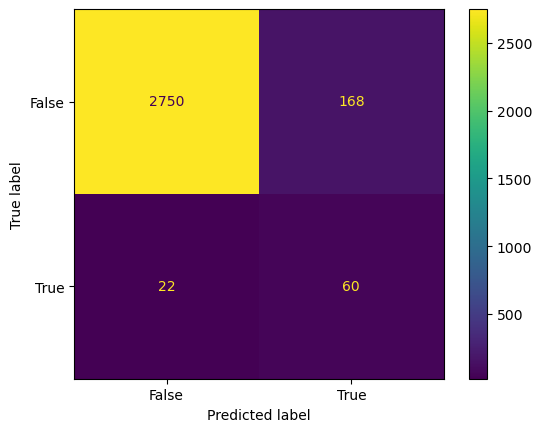

In [44]:
# Test model data real
df_pred_test_ac = df.sample(n=3000).reset_index(drop=True)

# df_pred_test_ac = df

X_pre_ac = df_pred_test_ac.iloc[:,:-1]
normalize(X_pre_ac)
Y_pre_ac = df_pred_test_ac.iloc[:,-1]

graph_X_ac =  create_graph_list(X_pre_ac)

pre_generator_ac = PaddedGraphGenerator(graphs=graph_X_ac)

t_gen = pre_generator_ac.flow(
    Y_pre_ac.index,
    symmetric_normalization=False,
) 
pre = [round(i[0]) for i in model.predict(t_gen)]
actual = [i for i in Y_pre_ac.values]

counter = 0

print('pre : actual')
for i in range(len(pre)):
    if(counter < 25):
        print(f'{pre[i]}   :   {actual[i]}')
    if pre[i] == actual[i]:
        counter += 1

print(f'acc: {counter/len(pre)}')
print(counter)

from collections import Counter

print("Thống kê bộ data predict:")
print(Counter(pre))
print("Thống kê bộ data actual:")
print(Counter(actual))

print(f'f1_score: {f1_score(pre, actual)}')
print(f'precision_score: {precision_score(pre, actual)}')
print(f'recall_score: {recall_score(pre, actual)}')

print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(actual, pre)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

print(classification_report(pre, actual, target_names=['No','Yes']))

In [113]:
model.save('model_20231007_ver02_0.7')

INFO:tensorflow:Assets written to: model_20231007_ver02_0.7\assets


INFO:tensorflow:Assets written to: model_20231007_ver02_0.7\assets


In [56]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 dropout_59 (Dropout)           (None, None, 1)      0           ['input_31[0][0]']               
                                                                                                  
 input_33 (InputLayer)          [(None, None, None)  0           []                               
                                ]                                                                 
                                                                                                  
 graph_convolution_39 (GraphCon  (None, None, 128)   128         ['dropout_59[0][0]',      

C:\Users\vvt\AppData\Local\Temp\ipykernel_18076\3283366064.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Yes', 'No'])


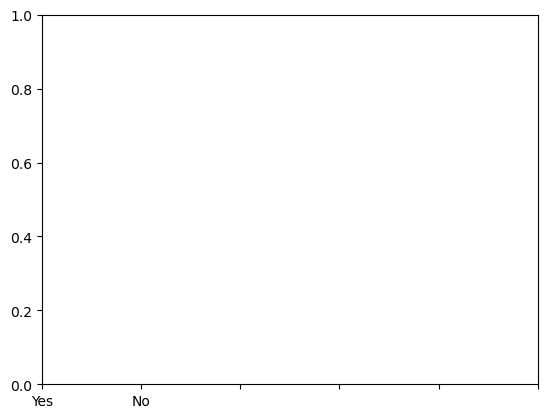

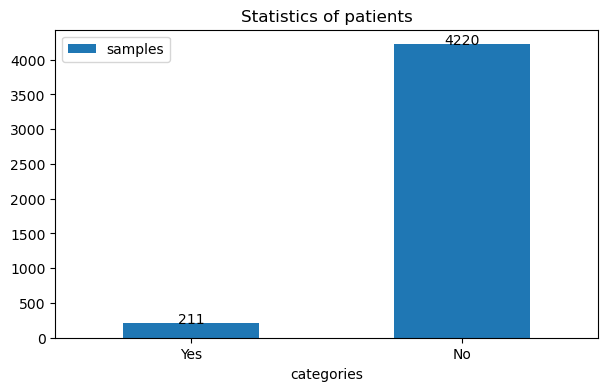

In [58]:
# Plot BNN Y/N
pct_bnn_df = pd.DataFrame()
pct_bnn_df['categories'] = ['Yes', 'No']
# print(data['bnn'].value_counts())
pct_bnn_df['samples'] = [Y.value_counts()[1], Y.value_counts()[0]]

ax1 = plt.subplot()
ax1.set_xticklabels(['Yes', 'No']) 

pct_bnn_df.plot(x='categories', y='samples', rot=0 ,kind='bar', figsize=(7,4))
for i, v in enumerate(pct_bnn_df['samples'].values):
    plt.text(i, v, v, ha = 'center')

plt.title("Statistics of patients")
plt.show()